In [1]:
%matplotlib inline
import os
import time
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import pyFAI
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 2023.5.0


# read folder

Agbeh_output_image.cbf


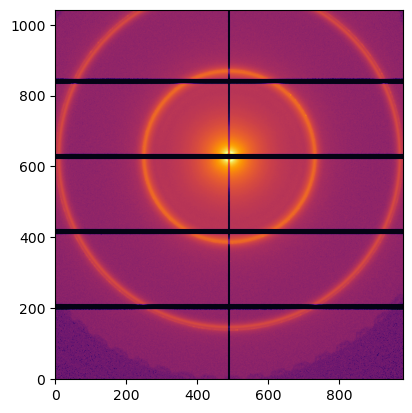

In [2]:
folder_path = r'C:Users\b_tassone\Desktop\Anjani\Python\Data_Reduction\Convert_and_calibrate'

# Loop through all files in the folder

filename = 'Agbeh_output_image.cbf'
# Open the cbs file and read the image data
frame = fabio.open(filename).data
# Do something with the image data here

# and now display the image
ax = jupyter.display(frame)
print (filename)

In [3]:
# This allow to measure approximatively the position of the beam center ...
x = 500 # x-coordinate of the beam-center in pixels
y = 650 # y-coordinate of the beam-center in pixels
d = 2800 # This is the distance in mm (unit used by Fit2d)
wl = 0.826565e-10 # Equivalent to 15 keV 

In [4]:
# Definition of the detector and of the calibrant:
pilatus = pyFAI.detector_factory("Pilatus1M")
behenate = CALIBRANT_FACTORY("AgBh")
behenate.wavelength = wl
behenate

AgBh Calibrant with 49 reflections at wavelength 8.26565e-11

In [5]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=pilatus, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.265650e-11 m
SampleDetDist= 2.800000e+00 m	PONI= 1.118000e-01, 8.600000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 2800.000 mm	Center: x=500.000, y=650.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.827Å

In [6]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry(filename, frame, calibrant=behenate, detector=pilatus, geometry=initial)
sg.extract_cp(max_rings=1)

ControlPoints instance containing 1 group of point:
AgBh Calibrant with 49 reflections at wavelength 8.26565e-11
Containing 1 groups of points:
# a ring 0: 317 points

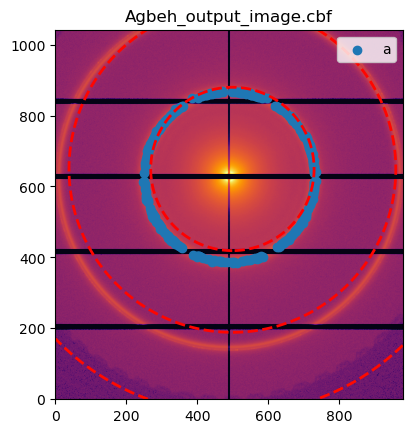

In [7]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
ax = jupyter.display(sg=sg)

In [8]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.265650e-11 m
SampleDetDist= 2.927049e+00 m	PONI= 1.079173e-01, 8.456233e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 2927.049 mm	Center: x=491.641, y=627.426 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.827Å

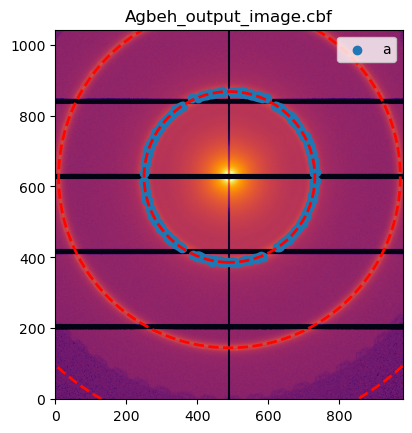

In [9]:
ax = jupyter.display(sg=sg)

In [17]:
#Save the geometry obtained
sg.geometry_refinement.save("Methanolysis_Dec2023_SAXS.poni")
with open("Methanolysis_Dec2023_SAXS.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Thu Dec  7 11:19:22 2023
poni_version: 2
Detector: Pilatus1M
Detector_config: {}
Distance: 2.927048886565239
Poni1: 0.10791728911499773
Poni2: 0.08456233051178537
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 8.26565e-11



(0.0, 2000.0)

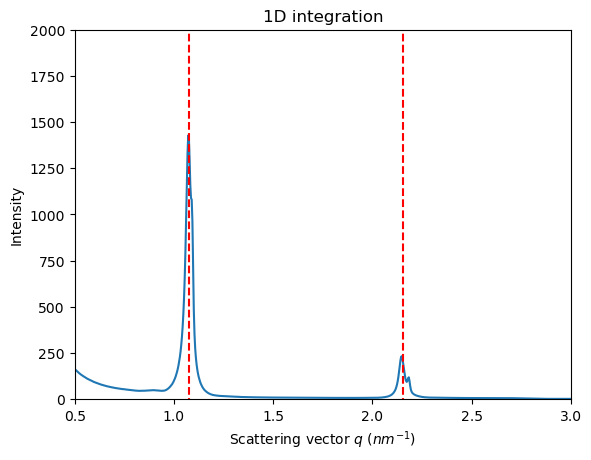

In [18]:
#Use the geometry to perform an azimuthal integration
ai = sg.get_ai()
res = ai.integrate1d(frame, 1000)
ax = jupyter.plot1d(res,calibrant=behenate)
#ax = jupyter.plot1d(res, calibrant=behenate) 
ax.set_xlim([0.5, 3])
ax.set_ylim([0,2000])
#plt.semilogy(res.radial, res.intensity, label=filename)